# EPMT Analysis Example Notebook

This notebook is intended to show how EPMT can be used to analyze performance characteristics (metadata) of FRE postprocessing (`frepp`) jobs, in addition to`refineDiag` and analysis scripts. The notebook walks through API queries to extract and display performance-related quantities for a given FRE experiment. This introduction only covers a small subset of EPMT's analysis capabilities, as it captures volumnous amounts of job, process, and thread-level data. 

EPMT-gathered metadata is stored in a database, with access provided by the EPMT Query API. The API provides functions that can return usable data in various formats: `pandas.DataFrame` objects (easy graphing and inspection), Python `dict` objects (dictionary, unique key/value pairs), job number lists (`terse`; fast), and `orm` database objects (fast/powerful/flexible/lazy). Data in these formats can then be rendered into plots/graphs/figures using standard Python libraries (e.g. `matplotlib`). EPMT also comes with some graphing functions for immediate use out-of-the-box, available in the `ui/` directory. Some of these will be used in this notebook.

## Starting EPMT and opening this notebook
To begin with this notebook, open a terminal and `ssh` in to any JHAN enabled analysis node (e.g. `an201`) and do:

```
module load epmt
epmt notebook -- --no-browser --ip=`hostname` --notebook-dir=/home/First.Last/path/to/your/notebooks

```
Above, the `--no-browser` option is required to keep an internet browser from opening up immediately via `ssh` session, and the `--ip` option is helpful for printing a full URL for accessing these notebooks through a web browser on a local machine. Navigate to the output URL in any browser. What comes up should be the `notebook-dir` directory specified above. To begin working through this notebook then, click on `Analysis-Example.ipynb`.

### Further Info
Documentation of EPMT's Query and Graphics APIs can be seen in the `Query-API` and `Graphing-API` notebooks also in this repository.

## Import Relevant Python Modules
First, import the `epmt_query` and `ui.graphing` modules in order to access the relevant commands for retrieving data and plotting it. Additionally importing the `pandas` package allows the use of `DataFrame` objects, which are considered a convenient format for conducting data analysis. To import, click on the code cell below, then press `shift`+`enter` to execute the commands in the cell.

In [3]:
# import  epmt query 
print('importing epmt_query')
import epmt_query as eq
# import matplot for better plotting functions
import sys
sys.path.insert(0,'/home/Ian.Laflotte/ians_py374/pip_experiment')
import matplotlib.pyplot as plt
import numpy as np
# import pandas. optional but helpful 'display.max_columns' arg shows all DataFrame columns when printing
print('importing pandas')
import pandas
pandas.set_option('display.max_columns', None)

importing epmt_query
importing pandas


## Retrieving and Peeking at Job Metadata
For this example notebook, let's grab the metadata of 1000 jobs currently in the DB. Note that in general EPMT job information is not stored permanenently, and old (>2 months) data are periodically removed. 

To get the desired metadata through EPMT, we use the `eq` object's `get_jobs` function with a limit argument `limit=1000`  One and a desired output format (`fmt='dict'`). One can also specify a desired tag for specific qualities of retrieved jobs, like experiment name (e.g. `tags='exp_name:c96_am4p0'`).

<!-- 
For this example notebook, the metadata of a 2-year AM5 model run by user `Chris.Blanton`, with output corresponding to 
```
/home/Chris.Blanton/am5/2022.01/c96L33_am4p0/gfdl.ncrc4-intel21-prod-openmp/stdout/postProcess
```
is provided. Note that in general EPMT job information is not stored permanenently, and old (>2 months) data are periodically removed. 

To get the metadata through EPMT, we use the `eq` object's `get_jobs` function with a experimental name tag (`tags='exp_name:c96_am4p0'`) and a desired output format (`fmt='dict'`). -->

<!-- freppscripts, refineDiag, and analysis -->
<!-- e.g. the pp jobs were tagged like (e.g. atmos 1980) -->
<!-- exp_component:atmos; -->
<!-- exp_name:c96L33_am4p0; -->
<!-- exp_time:19800101; -->
<!-- exp_platform:gfdl.ncrc4-intel21; -->
<!-- exp_target:prod-openmp; -->
<!-- exp_seg_months:12; -->
<!-- script_name:c96L33 -->
<!-- retrieve desired jobs to analyze -->
<!-- g_am4p0_atmos_19800101' -->
<!-- let's retrieve all jobs for one experiment -->
<!-- modify this to retrieve jobs for another experiment -->

In [4]:
# retrieve all jobs corresponding to below criteria/tag(s)
# potential criteria are before/after job start/end/creation times, 
# potential tags are exp_component, exp_name, exp_time, exp_platform, and exp_target (i.e. command line args to frepp)
# potential output formats are dict, pandas, terse, and orm
username = 'Avery.Kiihne'
jobs_all = eq.get_jobs(fltr=(eq.Job.user_id == username),
                       fmt='dict')
print(f'number of elements in jobs_all={len(jobs_all)}')
jobs_all[0]['start']

number of elements in jobs_all=142


datetime.datetime(2024, 1, 16, 12, 37, 26, 788064)

What does one recorded job's worth of metadata look like? We can print out a single job entry in the usual way, but python yaml library can make the printout more digestible for little effort like so:

In [51]:
from yaml import dump
## uncomment me and run me- large output warning!
#print(dump(data=jobs_all[0], default_flow_style=False))

We can get a further idea of what kind of data is in these jobs by `get_job_tags`

In [52]:
jobs_all_tags=eq.get_job_tags(jobs=jobs_all)
print(f'type(jobs_all_tags)={type(jobs_all_tags)}')
for key in jobs_all_tags:print(f'key={key}')

type(jobs_all_tags)=<class 'dict'>
key=exp_name
key=exp_time
key=exp_target
key=script_name
key=exp_platform
key=pp_is_canopy
key=exp_component
key=exp_seg_months
key=pp_chunk_a_months
key=pp_chunk_b_months
key=exp_component_source


If we print a specific key in the `jobs_all_tags` dict, we see the values assigned to that key across jobs. The pritn statement below shows us that across these 1000 jobs, the `exp_platform` tag value took on only six different values.

In [53]:
print(f'jobs_all_tags[exp_platform]=\n{jobs_all_tags["exp_platform"]}')

jobs_all_tags[exp_platform]=
gfdl.ncrc5-intel22-classic


What about `exp_name`? In this case, there's a lot of possible values, and so here this approach is not as helpful. It might be wise to do some looping over the retried jobs to get the info we need.

In [54]:
print(f'jobs_all_tags[exp_name]=\n{jobs_all_tags["exp_name"]}')

jobs_all_tags[exp_name]=
am5_c96L33_amip


## Selecting Relevant Metadata 

Note that `get_jobs` is grabbing the oldest 1000 jobs *ingested by the DB*. To start picking at this, let's sort the jobs by experimental component (`exp_component`) while we exclude jobs from other users. One possible way of doing this is to loop over the dictionary data itself as below.

In [55]:
# username of who's jobs we'd like to analyze, if desired
name=None
#name='Ian.Laflotte'
### a convenient way to grab one's own username
##import os
##name = os.environ.get('USER')

# sort jobs into refineDiag (rd), analysis (ana) and postprocessing (pp) categories
jobs_rd = []
jobs_ana = []
jobs_pp = []

found_exp_components={}
found_exp_names={} # count times we find an exp_name

for job in jobs_all:
    
    # skip jobs that are not the user's
    if name is not None:
        if job['user'] == name:
            continue
    
    job_exp_name=job['tags']['exp_name']
    exp_name_unique=True
    for already_found_name in found_exp_names: #check if exp_name unique
        if job_exp_name == already_found_name:
            exp_name_unique=False
            found_exp_names[already_found_name]+=1 #if not unique, add 1 to count
            break
            
    if exp_name_unique: #if unique, new entry
        found_exp_names[job_exp_name]=1

    
    job_exp_component=job['tags']['exp_component']
    exp_component_unique=True
    for already_found_component in found_exp_components: #check if exp_component unique
        if job_exp_component == already_found_component:
            exp_component_unique=False
            found_exp_components[already_found_component]+=1 #if not unique, add 1 to count
            break
            
    if exp_component_unique: #if unique, new entry
        found_exp_components[job_exp_component]=1
        
        
        
    # then, separate the jobs into pp, refineDiag, and analysis jobs
    if job_exp_component == 'refineDiag':
        jobs_rd.append(job)
    elif job_exp_component == 'analysis':
        jobs_ana.append(job)
    else:
        ## if desired, print out exp_component of jobs other than the two above
        #print('pp exp_component for this job is '+str(job['tags']['exp_component']))
        jobs_pp.append(job)

print(f'number of elements in jobs_rd ={len(jobs_rd )}')
print(f'number of elements in jobs_ana={len(jobs_ana)}')
print(f'number of elements in jobs_pp ={len(jobs_pp )}')
print('\n')

print(f'found {len(found_exp_components)} unique exp_components')
sorted_found_exp_components= sorted(found_exp_components.items(),key=lambda x:x[1],reverse=True)
print(f'top five:\n{sorted_found_exp_components[:5]}')
print('\n')

print(f'found {len(found_exp_names)} unique exp_names')
sorted_found_exp_names= sorted(found_exp_names.items(),key=lambda x:x[1],reverse=True)
print(f'top five:\n{sorted_found_exp_names[:5]}')

number of elements in jobs_rd =0
number of elements in jobs_ana=0
number of elements in jobs_pp =74


found 8 unique exp_components
top five:
[('land', 22), ('atmos_scalar', 18), ('atmos', 12), ('clean', 8), ('stage-history', 6)]


found 1 unique exp_names
top five:
[('am5_c96L33_amip', 74)]


## Plotting/Graphing Job Metadata 1

Now the fun part! A convenient function for making quick plots is the `gr` object's `graph_experiment` function, the code of which can be seen in file `ui/graphing.py`. `graph_experiment` will use `get_jobs` using the same experiment name as before, but only select the job numbers that also belong in `jobs_pp` (or `rd` or `ana` jobs). It uses the `pandas.DataFrame` format to average job times across experiment component, and then display the results as a bar graph. Run the below cells to show how wallclock (`duration`) and CPU times for each group of jobs.

In [56]:
# look at the type+name of a more-frequent exp_name
choice=0
print(type(sorted_found_exp_names[choice]))
print(sorted_found_exp_names[choice])

# it's a tupel, grab only the string
target_exp_name=sorted_found_exp_names[choice][0]
print(type(target_exp_name))
print(target_exp_name)

# title for plots
base_title=f'Avg Wall / CPU Time, {target_exp_name}'
print(f'base_title={base_title}')

<class 'tuple'>
('am5_c96L33_amip', 74)
<class 'str'>
am5_c96L33_amip
base_title=Avg Wall / CPU Time, am5_c96L33_amip


In [57]:
df = eq.get_jobs(jobs=jobs_all, tags={'exp_name':target_exp_name}, fmt='pandas')
df = df.sort_values('duration')
#df['tags'][:]

#for thing in df['tags']:print(thing['exp_component'])

## PLT analysis
The below section has been rewritten then expanded upon in order to convert the analysis into a matplotlib (plt) base.
The first several examples compare elements of how a specific job runs, broken down into each component of the simulation. For each component specified, we will run through,
and grab each statistic we want to use for the following plots.

In [58]:
#gathering data for plotting
#currently listing component names by hand, will need to automate
comp_list = ['land','atmos','stage-history','atmos_scalar','pp-starter','PLACE_HOLDER','land.static','clean']
averages_dur = []
averages_cpu = []
averages_rssmax = []
averages_wait = []
#runs a get job individually for each component
for comp in comp_list:
    jobs_comp = eq.get_jobs(fltr=(eq.Job.user_id == username),
                           tags = 'exp_component:'+comp,
                           fmt='pandas')
    #converts data into form for graph
    averages_dur.append(sum(jobs_comp['duration'])/len(jobs_comp['duration']))
    averages_cpu.append(sum(jobs_comp['cpu_time'])/len(jobs_comp['cpu_time']))
    averages_rssmax.append(sum(jobs_comp['rssmax'])/len(jobs_comp['rssmax']))
    averages_wait.append(sum(jobs_comp['time_waiting'])/len(jobs_comp['time_waiting']))

#Pull tags in order to get experiment name
job_tags=eq.get_job_tags(jobs=jobs_all)
experiment_name = job_tags['exp_name']

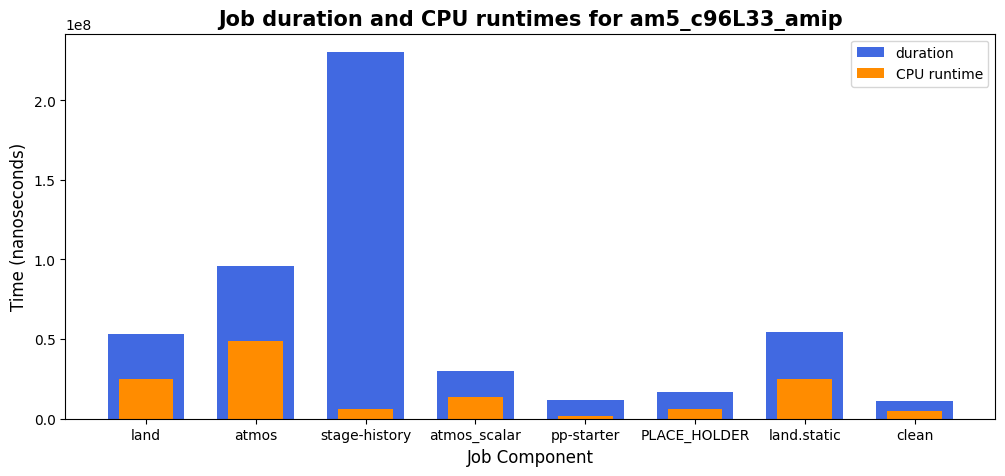

In [59]:
#Plot creation for comparing cpu and duration timing
plt.style.use('default')
plt.figure(figsize = (12, 5))
plt.bar(comp_list,averages_dur, label = 'duration', width = .7, color = 'royalblue')
plt.bar(comp_list,averages_cpu, label = 'CPU runtime', width = .5, color = 'darkorange')
#bells n whistles
plt.title('Job duration and CPU runtimes for '+experiment_name, fontweight ='bold', fontsize = 15)
plt.ylabel('Time (nanoseconds)', fontsize = 12)
plt.xlabel('Job Component', fontsize = 12)
plt.legend()
#cleanup
plt.tight_layout
plt.savefig('analysis_plots/general_plots/bar_duration_job_components.pdf', bbox_inches='tight', format = 'pdf')
plt.show()


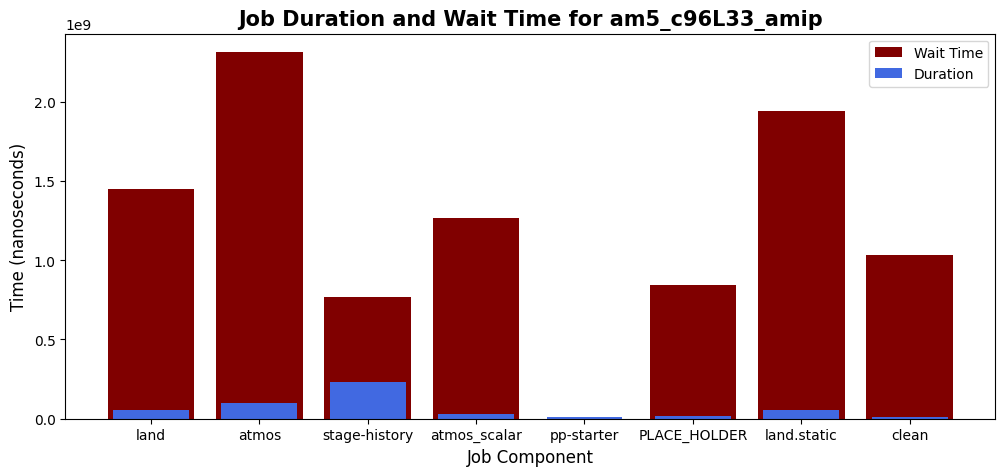

In [60]:
#Plot creation for comparing cpu and duration timing
plt.figure(figsize = (12, 5))
plt.style.use('default')
plt.bar(comp_list,averages_wait, label = 'Wait Time', width = .8, color = 'maroon')
plt.bar(comp_list,averages_dur, label = 'Duration', width = .7, color = 'royalblue')
#bells n whistles
plt.title('Job Duration and Wait Time for '+experiment_name, fontweight ='bold', fontsize = 15)
plt.ylabel('Time (nanoseconds)', fontsize = 12)
plt.xlabel('Job Component', fontsize = 12)
plt.legend()
#cleanup
plt.tight_layout
plt.savefig('analysis_plots/general_plots/bar_wait_job_components.pdf', bbox_inches='tight', format = 'pdf')
plt.show()


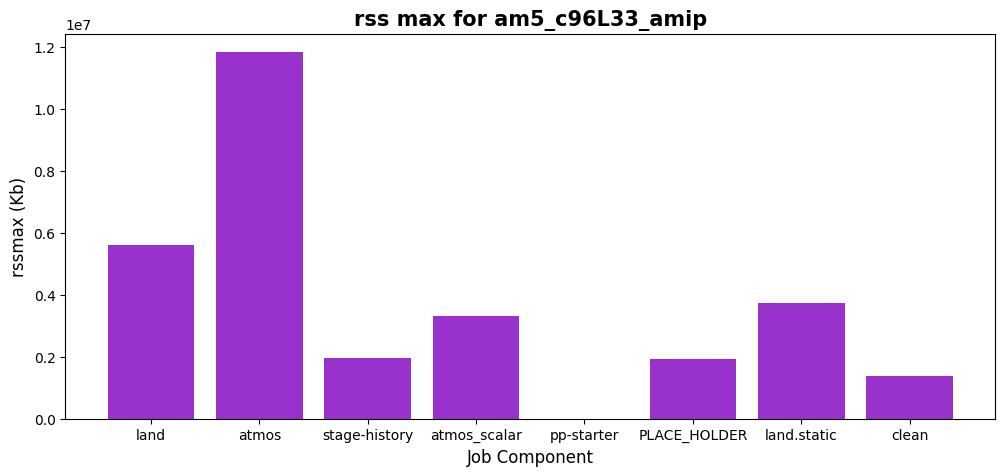

In [61]:
#Plot creation for comparing cpu and duration timing
plt.figure(figsize = (12, 5))
plt.style.use('default')
plt.bar(comp_list,averages_rssmax, label = 'rss max', width = .8, color = 'darkorchid')
#bells n whistles
plt.title('rss max for '+experiment_name, fontweight ='bold', fontsize = 15)
plt.ylabel('rssmax (Kb)', fontsize = 12)
plt.xlabel('Job Component', fontsize = 12)
#plt.legend()
#cleanup
plt.tight_layout
plt.savefig('analysis_plots/general_plots/bar_rssmax_components.pdf', bbox_inches='tight', format = 'pdf')
plt.show()


## rssmax of nodes
This next section is meant for looking at the rssmax of specific nodes.

this must be done slightly differently than above because we are looking at a dictionary entry inside of a tag.

In [45]:
#find rssmax, but for specific ranges
# retrieve all jobs corresponding to below criteria/tag(s)
#computationally heavy
job_num = 5000   #number of jobs grabbed
jobs_all = eq.get_jobs(limit=job_num, before=-5,
                       fmt='dict')

In [48]:
#pull specific pieces of data from jobs
nodelist = []
rssmax = []
for job_instance in range(job_num):
    if jobs_all[job_instance].get('rssmax') is None:
        continue
    nodelist.append(jobs_all[job_instance]['env_dict']['SLURM_NODELIST'])   #nodes are inside of dictionaries, making rectieval difficult
    rssmax.append(jobs_all[job_instance]['rssmax'])
combo_rss_node = np.array(sorted(list(zip(nodelist,rssmax))))  #combines the lists into a 2d array with each entry as (node,rss)
#for larger data sets, we cutoff everything below the 20 highest averages, for plot clarity

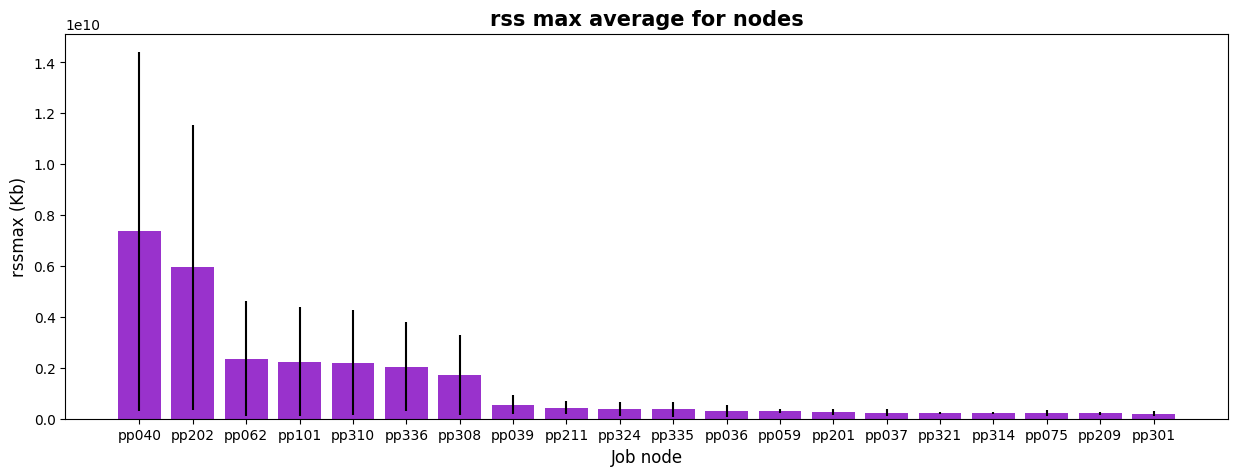

In [49]:
#This cell organizes the data and then plots it as a bar graph, with a maximum of 20 largest nodes
#sort the data and create a list of averages for rssmax
nodelist_fin = sorted(set(combo_rss_node[:,0]))   #sorted list of every unique node
rssmax_fin = []
standard_error = []
counter = 0   #this counts which unique node in the list we are on
temp_rssmax = []
for aa in range(len(nodelist)):
    if nodelist_fin[counter] == combo_rss_node[aa][0]:   #if the unique node currently in line = node of current rssmax value:
        temp_rssmax.append(rssmax[aa])
    else:   #triggers when new node reached
        counter += 1
        rssmax_fin.append(sum(temp_rssmax)/len(temp_rssmax))
        #error calculation
        standard_error.append(np.std(temp_rssmax)/(len(temp_rssmax))**.5)
        temp_rssmax = [rssmax[aa]]
    if aa == len(nodelist_fin)-1:   #covers final entry
        rssmax_fin.append(sum(temp_rssmax)/len(temp_rssmax))
        standard_error.append(np.std(temp_rssmax)/(len(temp_rssmax))**.5)
#for larger data sets, we cutoff everything below the 20 highest averages, for plot clarity
if len(nodelist_fin)> 20:
    temp_combo = np.array(sorted(zip(rssmax_fin,nodelist_fin,standard_error),reverse = True))
    nodelist_fin = []  
    rssmax_fin = []
    standard_error = []
    for cc in range(20):
        nodelist_fin.append(temp_combo[cc][1])
        rssmax_fin.append(float(temp_combo[cc][0]))
        standard_error.append(float(temp_combo[cc][2]))
    
            
#Plot creation for rssmax of nodes
plt.figure(figsize = (15, 5))
plt.bar(nodelist_fin,rssmax_fin, yerr = standard_error, label = 'rss max', color = 'darkorchid')
#bells n whistles
plt.title('rss max average for nodes', fontweight ='bold', fontsize = 15)
plt.ylabel('rssmax (Kb)', fontsize = 12)
plt.xlabel('Job node', fontsize = 12)
#plt.ylim(.9*min(rssmax_fin),1.1*max(rssmax_fin))
#plt.legend()
#cleanup
plt.tight_layout
plt.savefig('analysis_plots/general_plots/bar_rssmax_nodes.pdf', bbox_inches='tight', format = 'pdf')
plt.show()


## Plotting/Graphing Jobs based on bronx vs canopy


In [41]:
job_num = 5   #number of jobs grabbed
jobs_all = eq.get_jobs(limit=job_num, after=-1,
                       fmt='dict')

In [14]:
jobs_all[0]['annotations']

{'EPMT_JOB_TAGS': 'exp_name:am5_c96L33_amip;exp_platform:gfdl.ncrc5-intel22-classic;exp_target:prod-openmp;exp_component:pp-starter;exp_component_source:PLACE_HOLDER;exp_time:19810101T0000Z;exp_seg_months:P1Y;pp_chunk_a_months:24;pp_chunk_b_months:-1;script_name:pp-starter;pp_is_canopy:YES'}

check


dict